# Regression showdown

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [5]:
# dataset = "wine"
# train, test = datasets.load_uci_wine_regression()

# dataset = "power"
# train, test = datasets.load_uci_power()

dataset = "kin8nm"
train, test = datasets.load_uci_kin8nm()

# dataset = "naval"
# train, test = datasets.load_uci_naval()

# dataset = "rmnist_0_5"
# train, test = datasets.load_rotated_mnist(frac_train=0.8, num_train=None, target_digit=[1, 2, 3, 4, 5])

In [6]:
# train, test = datasets.load_1d_synthetic_dataset(5_000, 1_000, sort_data=False)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [7]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean(),
    }
    return res

In [8]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err_test = jnp.abs(y_test - yhat.ravel())
    
    # One-step-ahead absolute error
    err = jnp.abs(y.ravel() - pred.mean.ravel()).sum()
    
    
    res = {
        "test": err_test.mean(),
        "osa-error": err,
    }
    return res

## Test setup

In [9]:
key = jax.random.PRNGKey(3141)

In [135]:
n_warmup = 1000

X_warmup = X_train[:n_warmup]
y_warmup = y_train[:n_warmup]

X_learn = X_train[n_warmup:]
y_learn = y_train[n_warmup:]

warmup_train = (X_warmup[:-100], y_warmup[:-100])
warmup_test = (X_warmup[-100:], y_warmup[-100:])

```
dynamics_weights: gamma
init_cov: eta
emission_cov: r
dynamics_cov: q (steady-state assumption)
```

In [136]:
pbounds = {
    "log_init_cov": (-5, 0.0),
    "dynamics_weights": (0, 1.0),
    "log_emission_cov": (-7, 0.0),
}

pbounds_adapted = pbounds.copy()
pbounds_adapted.pop("log_emission_cov");

In [129]:
dynamics_weights = [0.0, 0.5, 1.0] # gamma
log_init_cov = np.log([0.01, 0.1, 1.0]) # eta
log_emission_cov = np.log([0.01, 0.1, 1.0]) # R

elements = product(dynamics_weights, log_init_cov, log_emission_cov)
for gamma, log_eta, log_R in elements:
    ...

## Model setup

In [133]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_train.shape
model = MLP(dim_out, activation=nn.elu)

In [134]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)

# Agent showdown

## Diag-EKF

In [160]:
optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback
)

In [161]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8769   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8817   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.8724   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.87     | 0.2608    | -1.635    | -3.692    |
| 5         | -0.872    | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.872    | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8764   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8818   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.8732   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.8846   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.8688   | 0.0       | -0.4391   | -5.0      |
| 12        | -0.6533   | 1.0       | 0.0       | -4.118    |
| 13        | -0.6387   | 1.0       | 0.0       | -3.73     |
| 14        | -0.8704   | 0.8951    | -0.03351  | -2.82     |
| 15    

In [162]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method="fdekf")
fd_ekf_estimator = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fdekf")
bel_fd_ekf, output_fd_ekf = fd_ekf_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (orth / fixed)

In [137]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)


optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [138]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -1.164    | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8833   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.8722   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.8699   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.872    | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.872    | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8754   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8762   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.8735   | 0.5706    | -3.641    | -0.6946   |
| 10        | -10.0     | 0.8348    | -6.26     | -4.698    |
| 11        | -0.6793   | 1.0       | 0.0       | -5.0      |
| 12        | -0.872    | 0.0       | -7.0      | 0.0       |
| 13        | -0.869    | 0.0       | 0.0       | -2.729    |
| 14        | -0.8714   | 0.0       | -1.825    | 0.0       |
| 15    

In [139]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_of_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_of, output_lofi_of = lofi_of_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (orth / adapted)

In [157]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=True,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds_adapted, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [158]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.8695   | 0.09029   | -1.882    |
| 2         | -0.8733   | 0.3974    | -0.8307   |
| 3         | -0.868    | 0.8411    | -3.756    |
| 4         | -0.8708   | 0.212     | -1.036    |
| 5         | -3.413    | 0.9059    | -2.834    |
| 6         | -0.8704   | 0.07426   | -0.4788   |
| 7         | -0.8615   | 0.8886    | -1.409    |
| 8         | -0.8695   | 0.5119    | -3.066    |
| 9         | -0.869    | 0.4028    | -4.237    |
| 10        | -0.8736   | 0.4765    | -1.048    |
| 11        | -0.8692   | 0.3321    | -3.429    |
| 12        | -0.8691   | 0.08691   | -3.008    |
| 13        | -0.8687   | 0.9647    | -4.308    |
| 14        | -0.8693   | 0.1841    | -2.74     |
| 15        | -0.9123   | 0.898     | -1.378    |
| 16        | -0.8689   | 0.594     | -4.898    |
| 17        | -0.8695   | 0.4652    | -3.121    |
| 18        | -0.8707   | 0.8774    | -1.41     |


In [159]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_oa_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_oa, output_lofi_oa = lofi_oa_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (full / fixed)

In [144]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [145]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8769   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8817   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.8724   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.87     | 0.2608    | -1.635    | -3.692    |
| 5         | -0.872    | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.872    | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8764   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8818   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.8732   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.8846   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.8688   | 0.0       | -0.4391   | -5.0      |
| 12        | -0.6402   | 1.0       | 0.0       | -4.118    |
| 13        | -0.6067   | 1.0       | 0.0       | -3.733    |
| 14        | -0.5204   | 1.0       | 0.0       | -2.887    |
| 15    

In [146]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_ff_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_ff, output_lofi_ff = lofi_ff_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (full / adapted)

In [147]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=True
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [148]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8694   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8774   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.8798   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.8691   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.8704   | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.8703   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8727   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8697   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.8757   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.8691   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.8691   | 0.8541    | -6.294    | -4.674    |
| 12        | -0.8689   | 0.04108   | -2.541    | -3.531    |
| 13        | -0.8689   | 0.2906    | -2.352    | -4.526    |
| 14        | -0.8689   | 0.1969    | -3.575    | -4.514    |
| 15    

In [149]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_fa_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_fa, output_lofi_fa = lofi_fa_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## ORFit

In [150]:
method = "orfit"
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)
orfit_estimator = lofi.RebayesLoFi(params_orfit, params_lofi, method=method)
bel_orfit, output_orfit = orfit_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## FC-EKF

In [163]:
optimizer, apply_fn, n_features = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [164]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8769   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8817   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.8724   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.87     | 0.2608    | -1.635    | -3.692    |
| 5         | -0.872    | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.872    | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8764   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8818   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.8732   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.8846   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.8688   | 0.0       | -0.4391   | -5.0      |
| 12        | -0.6418   | 1.0       | 0.0       | -4.118    |
| 13        | -0.6103   | 1.0       | 0.0       | -3.733    |
| 14        | -0.5267   | 1.0       | 0.0       | -2.888    |
| 15    

In [165]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method="fcekf")
fc_ekf_estimator = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fcekf")
bel_fc_ekf, output_fc_ekf = fc_ekf_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## Plot results

In [166]:
colors = {
    "lofi-of": "tab:blue",
    "lofi-oa": "tab:orange",
    "lofi-ff": "tab:red",
    "lofi-fa": "tab:pink",
    "orfit": "tab:green",
    "fd-ekf": "tab:purple",
    "fc-ekf": "tab:gray",
}

In [167]:
%%time
methods = {
    "lofi-of": output_lofi_of,
    "lofi-oa": output_lofi_oa,
    "lofi-ff": output_lofi_ff,
    "lofi-fa": output_lofi_fa,
    "orfit":   output_orfit,
    "fd-ekf": output_fd_ekf,
    "fc-ekf": output_fc_ekf,
}

methods = jax.tree_map(np.array, methods)

CPU times: user 3.76 ms, sys: 2.35 ms, total: 6.11 ms
Wall time: 4.38 ms


In [168]:
data = {
    key: methods[key]["test"]
    for key in methods
}

data = pd.DataFrame(data)

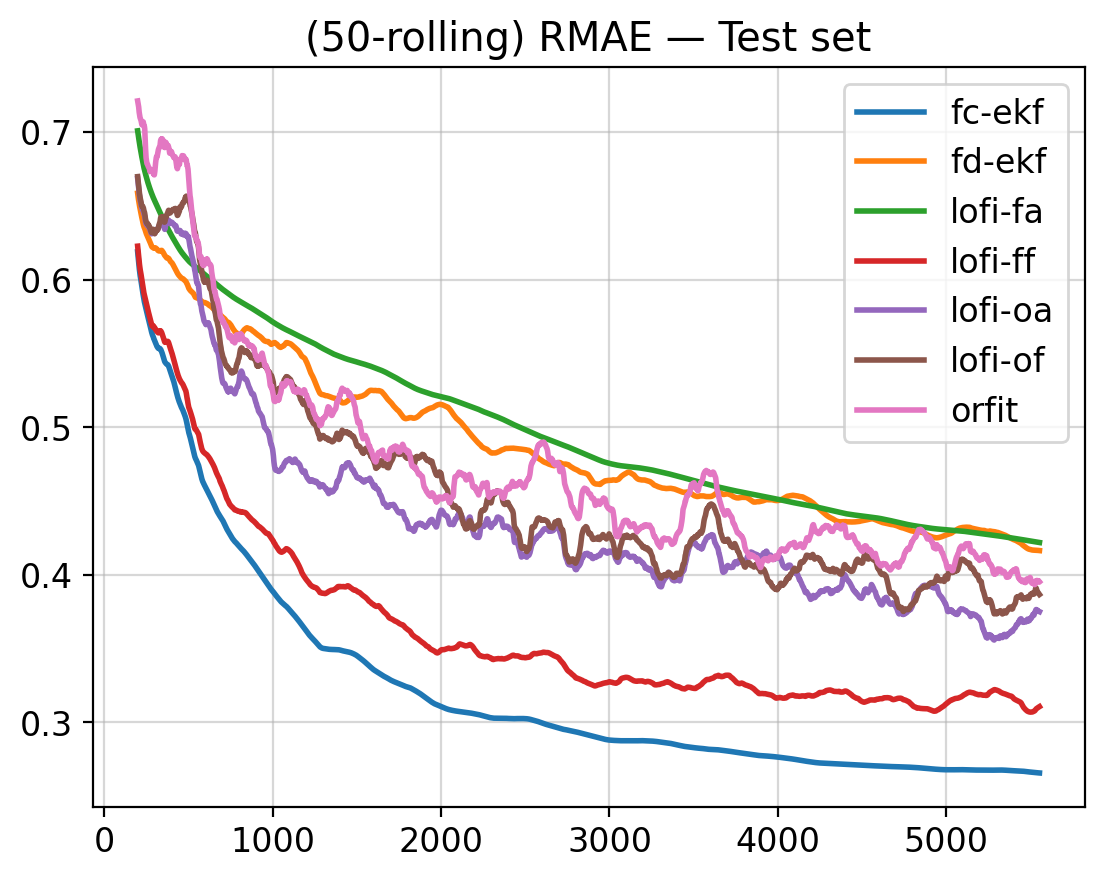

In [169]:
data.rolling(200).mean().plot()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

# Simulations

In [170]:
def eval_runs(key, num_runs_pc, estimator):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = estimator.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [171]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [172]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 2 * std_sim
    ubound = mean_sim + 2 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

## Run simulations

In [173]:
agents = {
    "lofi-of": lofi_of_estimator,
    "lofi-oa": lofi_oa_estimator,
    "lofi-ff": lofi_ff_estimator,
    "lofi-fa": lofi_fa_estimator,
    "orfit":   orfit_estimator,
    "fd-ekf":  fd_ekf_estimator,
    "fc-ekf":  fc_ekf_estimator,
}



sims = {}
n_agents = len(agents)
for name, agent in tqdm(agents.items(), total=n_agents):
    res = eval_runs(key, num_runs_pc=5, estimator=agent)
    sims[name] = jax.tree_map(np.array, res)

  0%|          | 0/7 [00:00<?, ?it/s]

In [174]:
jax.tree_map(np.shape, sims)

{'fc-ekf': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'fd-ekf': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-fa': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-ff': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-oa': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-of': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'orfit': {'osa-error': (40, 5554), 'test': (40, 5554)}}

## Plots

### Plot rolling RMAE on the test set

In [175]:
collection = {
    agent: pd.DataFrame(res["test"]).T
    for agent, res in sims.items()
}

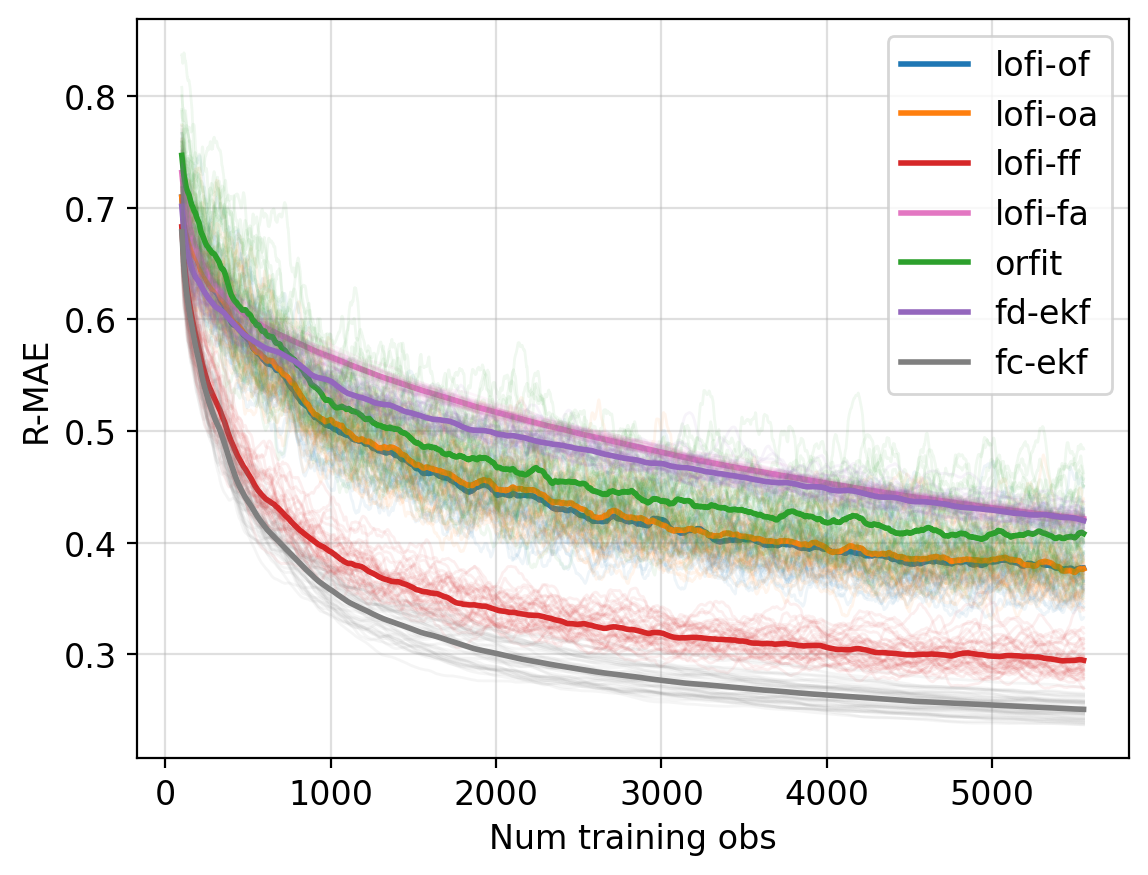

In [176]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/bounds-{dataset}.pdf")

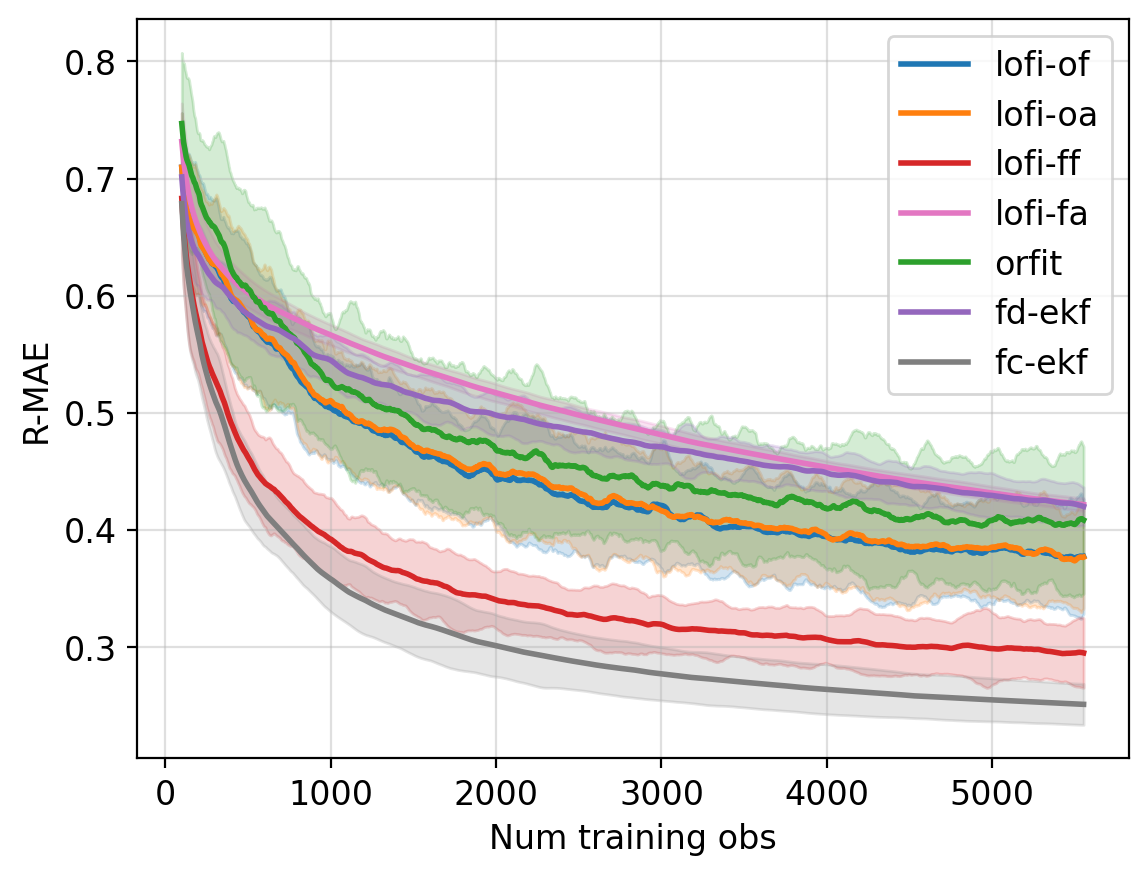

In [177]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

In [178]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

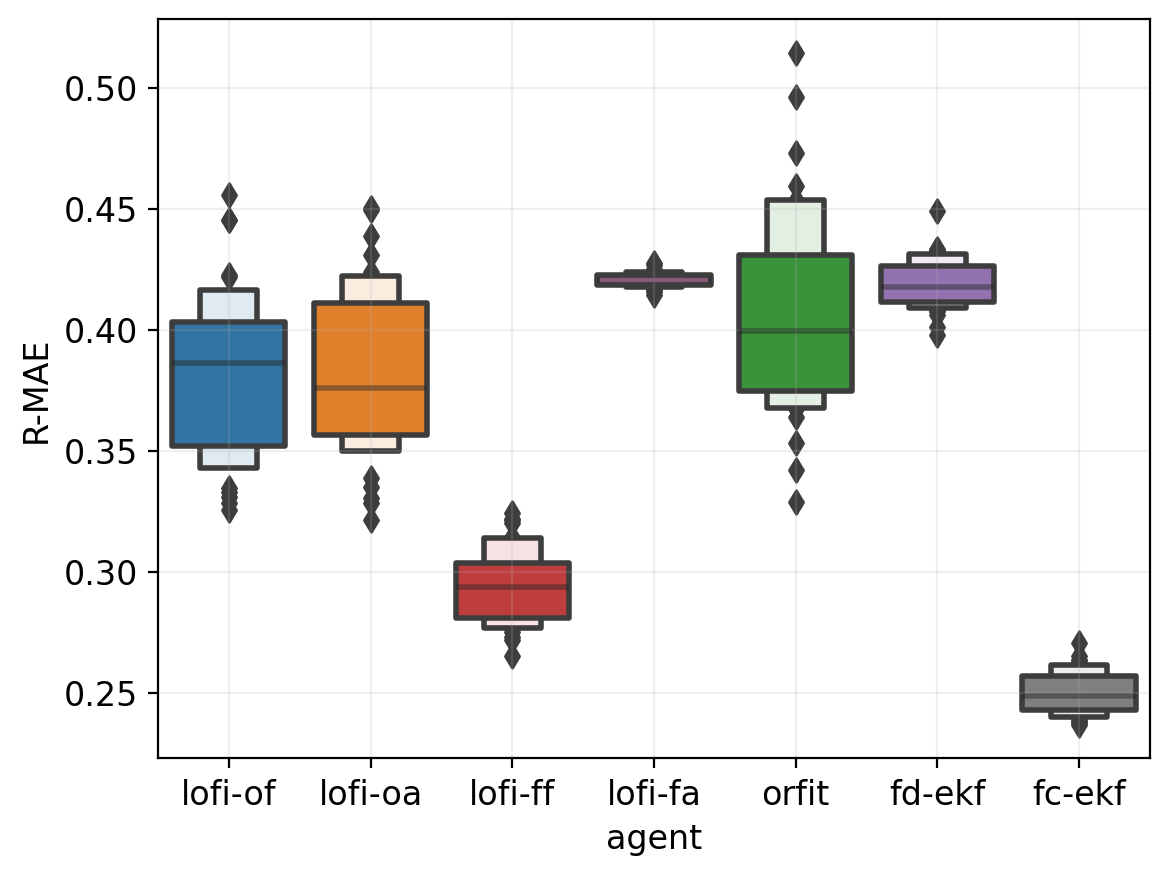

In [179]:
sns.boxenplot(
    x="agent",
    y="R-MAE",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="R-MAE")
)
plt.grid(alpha=0.2)
plt.savefig(f"output/last-metric-{dataset}.pdf")

### Plot rolling RMAE on the one-step-ahead posterior predictive

In [180]:
collection = {
    agent: pd.DataFrame(res["osa-error"]).T
    for agent, res in sims.items()
}

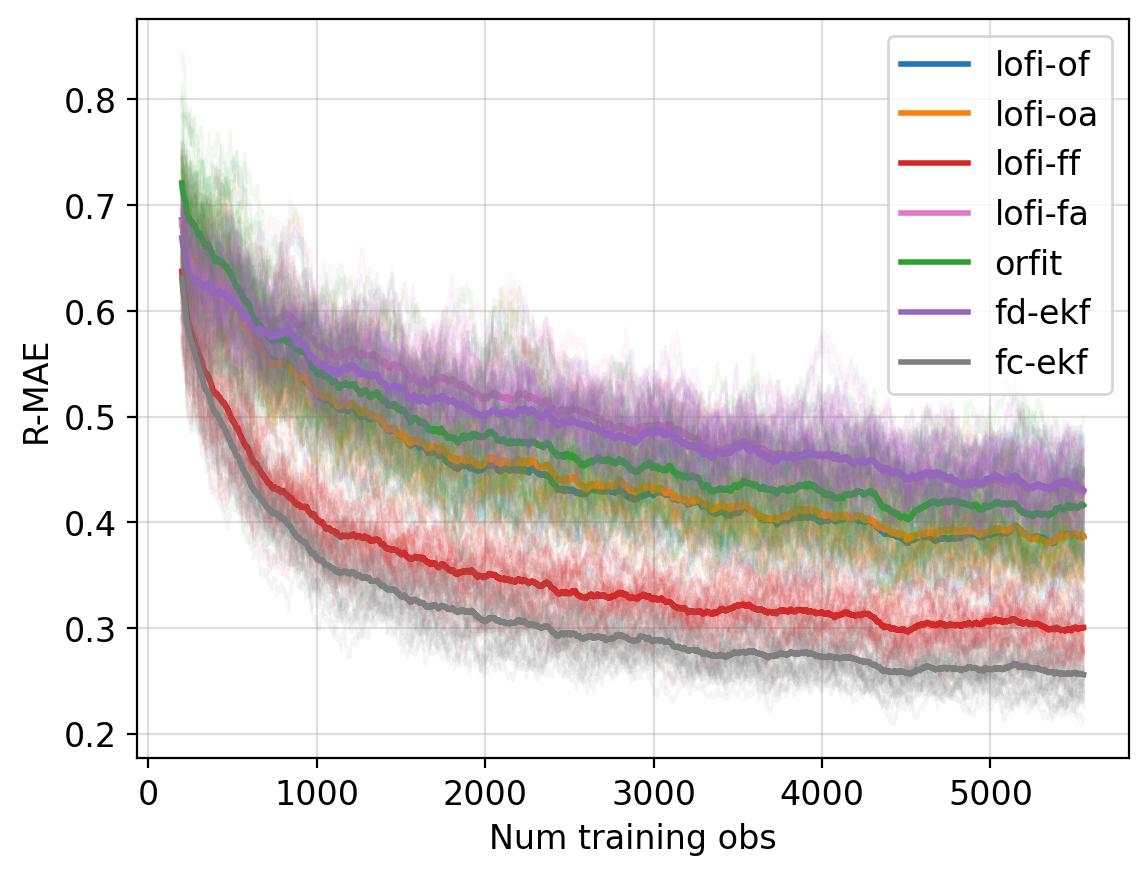

In [181]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")

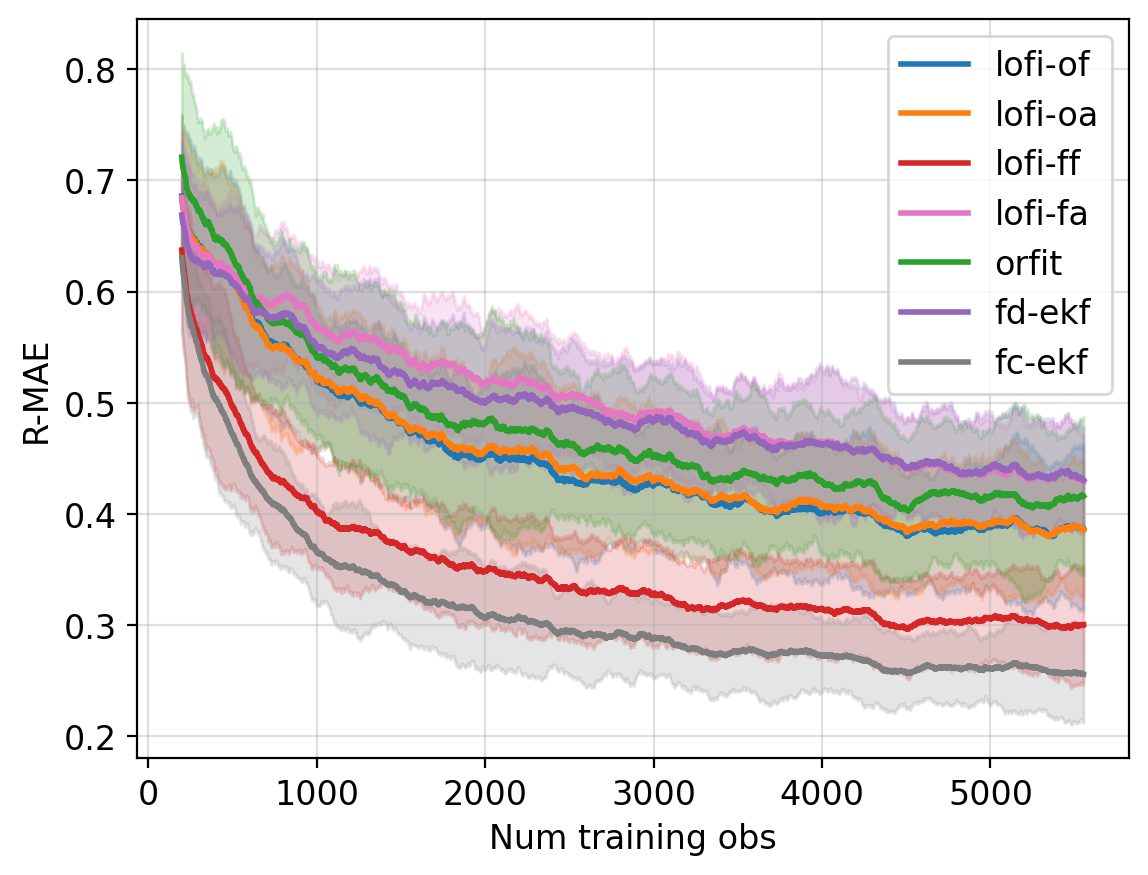

In [182]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-bounds-{dataset}.pdf")